# Setup

In [ ]:
from IPython.core.debugger import set_trace

set_trace()

In [1]:
import os
if not 'notebookDir' in globals():
    notebookDir = os.getcwd()
print('notebookDir: ' + notebookDir)
os.chdir(notebookDir)

notebookDir: /home/user/Documents/Github/Uni/Master/TUM_Praktikum_NLP_Explainability/understanding-opinions-on-social-media/tasks


# Training

In [2]:
import pytorch_lightning as pl
from nlp_utils.data_module import SemEvalDataModule
from nlp_utils.model import CustomDistilBertModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.utilities.seed import seed_everything
%load_ext tensorboard
seed_everything(42)

Global seed set to 42


42

In [3]:
# Start tensorboard
! pkill tensorboard
! rm -r /tmp/.tensorboard-info
%tensorboard --logdir lightning_logs --bind_all

rm: cannot remove '/tmp/.tensorboard-info': No such file or directory


In [4]:
config = {
    'batch_size': 32,
    'dataset_path': '../../data/processed/SemEval/stance/SemEval-stance_preprocessed.csv',
    'learning_rate': 0.01,
    'column_goldlabel': 'Stance',
    "category_group_id": False,
    "category_type": False,
    "category_tld": False,
}

In [5]:
data_module = SemEvalDataModule(num_workers=4, config=config)
data_path = data_module.prepare_data()
data_module.setup('')
# tokenizer for decoding sentences
tokenizer = data_module.get_tokenizer() 
config['vocab_size'] = len(data_module.vocab) 

## Ideas
* don't freeze bert params
* use lr scheduler
* use more features than just the text, i.e. especially sentiment
* change F1 score to micro
* use hyperparams from one of the papers below
* use position encoding in Bert model

## To Do's
* change config, s.t. default config can be used as is
* rewrite validation or test to output some visualization (maybe also SHAP values)
* use SHAP to get explanations
* change structure of setup and prepare_data

* Parameters from https://arxiv.org/pdf/2103.01664.pdf:
Our data set was divided into 80% for training and 20% for
testing. Each model was trained with a batch size of 16,
a learning rate (Adam) of 5 · 10−5, a decay of 0.01, a maximal sentence length of 100 and a validation split of 0.2. Further, we set the number of epochs to 10 and saved the best model on the validation set for testing.

* Idea from https://arxiv.org/pdf/2103.00747.pdf:
Use TreeSHAP for explanations

* Look here https://arxiv.org/pdf/2012.14353.pdf for interesting plots of explanations

* Get Feature importance by masking like here: https://arxiv.org/pdf/2009.04095.pdf

* Strategy from https://arxiv.org/pdf/2006.04884.pdf:
Unless mentioned otherwise, we follow the default fine-tuning strategy recommended by Devlin
et al. (2019): we fine-tune uncased BERTLARGE (henceforth BERT) using a batch size of 16 and a
learning rate of 2e−5. The learning rate is linearly increased from 0 to 2e−5 for the first 10% of
iterations—which is known as a warmup—and linearly decreased to 0 afterward. We apply dropout
with probability p = 0.1 and weight decay with λ = 0.01. We train for 3 epochs on all datasets
and use global gradient clipping. Following Devlin et al. (2019), we use the AdamW optimizer
(Loshchilov and Hutter, 2019) without bias correction.
Repo online at: https://github.com/uds-lsv/bert-stable-fine-tuning
Hyperparams for BERT: Epochs (3,10,20), lr (1e-5 till 5e-5), lr schedule (warmup-linear), batch size (16), Adam eps (1e-6), Adam beta1 (0.9), Adam beta2 (0.999), Adam bias correction (True, False), Dropout (0.1), weight decay (0.01), clipping gradient norm (1.0), number of random seeds (25)

* Analysis of several stance datasets: https://arxiv.org/pdf/2104.07467.pdf

In [6]:
model = CustomDistilBertModel(config)

early_stop_callback = EarlyStopping(
   monitor='val_epoch_F1',
   min_delta=0.00,
   patience=3,
   verbose=False,
   mode='max',
   stopping_threshold=0.70
)

cwd = os.getcwd()
save_folder = os.path.join(cwd, "../logs/StancePrediction_SemEval")

class MyPrintingCallback(Callback):

    def on_fit_start(self, trainer, pl_module):
        print('Starting to train!')

    def on_fit_end(self, trainer, pl_module):
        print('Finished training')

    def on_test_start(self, trainer, pl_module):
        print('Start to test')

    def on_test_end(self, trainer, pl_module):
        print('Finished testing')

checkpoint_callback = ModelCheckpoint(monitor='val_epoch_F1', filename='{epoch}-{val_loss:.2f}-{val_epoch_F1:.2f}', save_top_k=3, mode='max')


In [7]:
# Standard trainer
trainer = pl.Trainer(gpus=0,
                     log_every_n_steps=1,
                     flush_logs_every_n_steps=1,
                    callbacks=[MyPrintingCallback(), checkpoint_callback], deterministic=True, default_root_dir=save_folder, max_epochs=20) # gradient_clip_val=0.5, stochastic_weight_avg=True, check_val_every_n_epoch=10, num_sanity_val_steps=2, overfit_batches=0.01

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [8]:
# fast_dev_run=True -> runs one train, validate, test cycle
trainer = pl.Trainer(gpus=0, fast_dev_run=True, deterministic=True, default_root_dir=save_folder)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).


## LR Finder


  | Name            | Type            | Params
----------------------------------------------------
0 | train_metric    | F1              | 0     
1 | val_metric      | F1              | 0     
2 | test_metric     | F1              | 0     
3 | bert            | DistilBertModel | 66.4 M
4 | distilbert_tail | Sequential      | 590 K 
5 | classifier      | Linear          | 3.1 K 
----------------------------------------------------
593 K     Trainable params
66.4 M    Non-trainable params
67.0 M    Total params
267.826   Total estimated model params size (MB)
Global seed set to 42
Finding best initial lr: 100%|██████████| 100/100 [01:50<00:00,  1.28s/it]Restored states from the checkpoint file at /home/user/Documents/Github/Uni/Master/TUM_Praktikum_NLP_Explainability/understanding-opinions-on-social-media/logs/StancePrediction_SemEval/lr_find_temp_model.ckpt
<ipython-input-11-bdb22eae3faf>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a

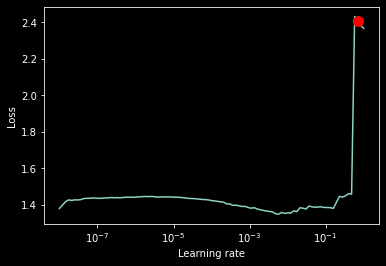

In [11]:
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model, datamodule=data_module)
# Results can be found in
lr_finder.results
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)
# update hparams of the model
#model.hparams.learning_rate = new_lr

## Train

In [8]:
# train model  
model.hparams.learning_rate = 0.01  
trainer.fit(model, datamodule=data_module)

_epoch=1.180]
Epoch 3: 100%|██████████| 1314/1314 [35:33<00:00,  1.62s/it, loss=1.21, v_num=0, train_loss_step=1.290, train_loss_epoch=1.170]
Finished training


In [8]:
trainer.test(datamodule=data_module)

AttributeError: 'NoneType' object has no attribute 'train_dataloader'

## Test

In [ ]:
# use model checkpoint to save model from time to time -> auto load best model from checkpoints
PATH = checkpoint_callback.best_model_path

#loading
model = MyLightingModule.load_from_checkpoint(PATH)
model.freeze()

x = some_data
pred = model(x)
text_pred = data_module.label_encoder.inverse_transform(pred) #get strings instead of numbers

# for testing
# (1) load the best checkpoint automatically (lightning tracks this for you)
trainer.test(datamodule=dm)

# (2) don't load a checkpoint, instead use the model with the latest weights
trainer.test(datamodule=dm, ckpt_path=None)

# (3) test using a specific checkpoint
trainer.test(datamodule=dm, ckpt_path='/path/to/my_checkpoint.ckpt')

# (4) test with an explicit model (will use this model and not load a checkpoint)
trainer.test(datamodule=dm, model)

# Evaluation

In [ ]:
import pandas as pd
from nlp_utils.data_module import PlainCrowdTangleDataModule, CrowdTangleDataModule, GroupId2Name, inverse_transform
from nlp_utils.model import BaseModel, BiLSTMModel
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from glob import glob
import ipywidgets as widgets
from tqdm.notebook import tqdm
import pandas as pd
import torch
import seaborn as sb
import re
%load_ext tensorboard

In [ ]:
# Start tensorboard
! pkill tensorboard
! rm -r /tmp/.tensorboard-info
%tensorboard --logdir lightning_logs --bind_all

In [ ]:
# Select a model
w = widgets.Dropdown(
    options=glob('lightning_logs/*/checkpoints/*.ckpt'),
    description='Select a checkpoint:'
)
w

In [ ]:
model_version = re.findall("version_[0-9]+", w.value)[0]
model = BaseModel.load_from_checkpoint(w.value)

torch.no_grad()
model.eval()
data_module = SemEvalDataModule(config=model.config)
data_module.setup('')
model.config, model_version

## Validation Set Results

In [ ]:
df_dicts = []
val_loader = data_module.val_dataloader()
#groupid2name = GroupId2Name(model.config)
for y_lst, encoded_texts_lst, category_vectors_lst, features in tqdm(iter(val_loader),total=len(val_loader)):
    
    result = model(encoded_texts_lst, category_vectors_lst)

    for y_hat, y, encoded_text, category_vector in zip(result, y_lst, encoded_texts_lst["input_ids"], category_vectors_lst):
        decoded_categories = inverse_transform(category_vector.reshape(1, -1), model.config, data_module.class_encoder)
        df_dicts.append({**{
            'prediction': float(y_hat),
            'gold label': float(y),
            'text': data_module.tokenizer.decode(encoded_text).replace(' [PAD]','')
        },**decoded_categories})
#encoded_texts
#data_module.tokenizer.decode(encoded_texts["input_ids"][0]).replace(' [PAD]','')
df = pd.DataFrame.from_dict(df_dicts)
df

In [ ]:
sb.histplot(data=df['prediction']).set_title(model_version)

# Analysis

In [ ]:
import pandas as pd
import seaborn as sb
from pathlib import Path
sb.set_context(rc = {'patch.linewidth': 0.0})

In [ ]:
dataset_path = Path('../../data/SemEval/stance/SemEval-stance.csv')

In [ ]:
df = pd.read_csv(dataset_path,low_memory=False)
dataset_name = dataset_path.stem
figure_path = Path('./figures/' + dataset_name + '/')
figure_path.mkdir(parents=True, exist_ok=True)
dataset_name, str(figure_path)

In [ ]:
#df['Type'].value_counts().plot(kind='bar')
plt = sb.countplot(y="Type", data=df)
plt.set(ylabel="", xlabel="Count")
#plt.figure.savefig(f'{figure_path}/post_types_dist.pdf', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
plt = sb.displot(df[df['Message'].str.len() < 600]['Message'].str.len())
plt.set(xlabel="Message length (characters)")
#plt.savefig(f'{figure_path}/message_length_dist.pdf', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
df_score_filtered = df[(df.reactions_sum < 2000)]
plt = sb.histplot(data=df_score_filtered['reactions_sum'], bins=100)
plt.set(xlabel="Number of Reactions")
#plt.figure.savefig(f'{figure_path}/reactions_dist.pdf', bbox_inches = 'tight', pad_inches = 0)